In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit #look into how this works--it is important to understand/properly use it
import scipy
import seaborn as sns
import pandas as pd

#path = "../Data_ExcelAcquisition/Configuration_5/ScintUp1100_ScintDn1250_TPCPMT1350_NoDrift/"#tot_evt = 200
#path = "../Data_ExcelAcquisition/Configuration_5/ScintUp1100_ScintDn1250_TPCPMT1350_NoDrift_ii/"#tot_evt = 200
#path = "../Data_ExcelAcquisition/Configuration_5/ScintUp1100_ScintDn1250_TPCPMT1350_NoDrift_Merged/"#tot_evt = 1200

path = "../Data_ExcelAcquisition/Configuration_5/C7600_LSF1680_ThGUp1460_ThGDnGND_PMesh400_TPC1350_ii/"#tot_evt = 1000
#path = "../Data_ExcelAcquisition/Configuration_5/C7600_LSF1680_ThGUp1460_ThGDnGND_PMesh400_TPC1350_iii/"#tot_evt = 917
#path = "../Data_ExcelAcquisition/Configuration_5/C7600_LSF1680_ThGUp1460_ThGDnGND_PMesh400_TPC1350_iv/"#6387

#path = "/Volumes/UNTITLED/C7600_LSF1680_ThGUp1460_ThGDnGND_PMesh400_TPC1350_ii/"#tot_evt = 1000


in_evt = 0
tot_evt = 1000
volt_lim = -0.009
sat_lim = 0.03
Amp_good_int = 0.00007 
Max_good_amp = 0.5 #parameter to check for sparks
trig_offset =  0. 

filetype = 0
f = open(path+"result.txt",'r')


6


In [2]:
ampl_TPC = []
all_ampl_TPC =[]
all_good_evt_flag = []
time_TPC = []
ampl_Scint = []
time_Scint = []
ampl_ScintDn = []
time_ScintDn = []
dum_wf_sum= 0
wf_sum_Scint = []
wf_sum_TPC = []
time_st = []
bin_info=[]
Int_aft = []
Int_bef = []
Int_aft_cut1 = []
Int_bef_cut1 = []
Max_aft = []
Max_aft_time = []
Max_bef_time = []
Max_bef = []
sat_evt = []
sat_evt2 = []
good_evt = []
good_evt_bef = []
evt_no = []
good_evt_flag = []

base_dump = []

for i in range(tot_evt):
    ampl_TPC.append([])    
    time_TPC.append([])
    ampl_Scint.append([])
    time_Scint.append([])
    ampl_ScintDn.append([])
    time_ScintDn.append([])
    Int_bef.append(0)
    Int_aft.append(0)
    Max_bef.append(-1)
    Max_aft_time.append(-99)
    Max_bef_time.append(-99)
    Max_aft.append(-1)
    evt_no.append(i)
    base_dump.append([])


#read data and store them in a list of list
dis = f.readlines()
f.close()
for i in dis:
        evt_,ch_,time_,ampl_ = i.split(',')
        if (ch_ == "C1" and int(evt_) < tot_evt): 
                ampl_Scint[int(evt_)].append(float(ampl_))   
                time_Scint[int(evt_)].append(float(time_))
        if (ch_ == "C2" and int(evt_) < tot_evt): 
                ampl_ScintDn[int(evt_)].append(float(ampl_))   
                time_ScintDn[int(evt_)].append(float(time_))       
        elif (ch_ == "C4" and int(evt_) < tot_evt):
                ampl_TPC[int(evt_)].append(float(ampl_))
                time_TPC[int(evt_)].append(float(time_))


#----------------
#dump all amplitudes in one big amplitude file. do the same for other as well
#----------------

base_events = 100 
base_dump_all = []
for i in  range(0,base_events):
    for j in range(len(ampl_TPC[0])):
        base_dump[i].append(ampl_TPC[i][j]*100)   
        base_dump_all.append(ampl_TPC[i][j]*100)
        if (time_TPC[i][j] > trig_offset - 10e-6):
            break
            

 
            



In [3]:
print(base_dump[0])

[-1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.200004, -2.450004, -1.8250039999999998, -1.8250039999999998, -1.200004, -1.8250039999999998, -2.450004, -2.450004, -1.8250039999999998, -1.8250039999999998, -2.450004, -2.450004, -1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -1.8250039999999998, -2.450004, -1.8250039999999998, -1.200004, -1.8250039999999998, -2.450004, -2.450004, -1.200004, -1.8250039999999998, -2.450004, -2.450004, -1.8250039999999998, -1.200004, -2.450004, -2.450004, -1.8250039999999998, -1.8250039999999998, -

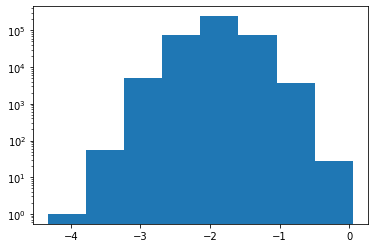

In [4]:
plt.hist(base_dump_all, bins = 8, log = True);

In [5]:
print(np.mean(base_dump_all))

-1.8343946162476261


In [6]:
#next we wish to find what actual data values our data acquisition system can create/store. This will help us determine out bins for the histogram. 
sbda=np.sort(base_dump_all) #bdas stands for "sorted_base_dump_all"
base=sbda[len(sbda)-1]
increment=sbda[1]-sbda[0]
for j in range(1,len(sbda)-1):
    diff=sbda[j+1]-sbda[j]
    if ((diff>0)and(diff<increment)):
        increment=diff
print(base)
print(increment)
minval=sbda[0]
print(minval)
maxval=sbda[len(sbda)-1]
print(maxval)

0.0499961
0.6249999999999998
-4.325004
0.0499961


In [7]:
bin_edges=np.arange(minval-(0.5*increment), maxval+(1*increment), increment) #maked the most logical bins based on the data we have
print(bin_edges)

[-4.637504 -4.012504 -3.387504 -2.762504 -2.137504 -1.512504 -0.887504
 -0.262504  0.362496]


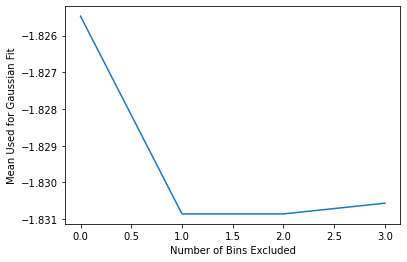

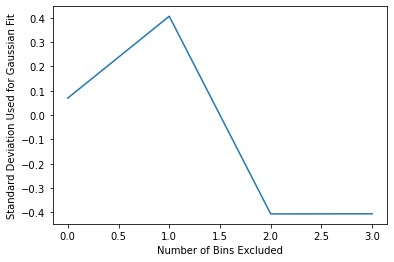

In [8]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    amp, mu, sigma = p
    return amp*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (amp, mu and sigma above)
p0 = [100000., -1.825, 1.]

offset=4 #offset how far from the right edge we want to go--we need to fit at least 3 data points!!
hist, utilised_bin_edges = np.histogram(base_dump_all, bins=bin_edges) #get hist and bin_edges
#could also use: bin_centers=np.arange(minval, maxval, increment)
bin_centers = .5*(bin_edges[:-1] + bin_edges[1:]) #get bin_centers--these should be the possible readout values of the data from above anyways...
means = [None]*(len(bin_centers)-offset)
stddevs = [None]*(len(bin_centers)-offset)
for m in range(0,(len(bin_centers)-offset)):
    A = bin_centers[m:len(bin_centers)] #values of bin_centers of only the part you need
    B = hist[m:len(hist)] #values of histogram of only the part you need
    coeff, var_matrix = curve_fit(gauss, A, B, p0=p0) #I need to research exactly what this function does and how it fits the curve!!!

    # Get the fitted curve
    #hist_fit = gauss(bin_centers, *coeff)
    means[m] = coeff[1]
    stddevs[m] = coeff[2]
    

#plt.plot(bin_centers, hist, label='Test data')
#plt.plot(bin_centers[m:len(bin_centers)], hist_fit, label='Fitted data')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
#print('Fitted mean = ', coeff[1])
#print('Fitted standard deviation = ', coeff[2])

#We plot the fit parameters as a function of m to see where the influence of the PMT noise stops. 
plt.plot(range(0,(len(bin_centers)-offset)), means)
plt.xlabel("Number of Bins Excluded")
plt.ylabel("Mean Used for Gaussian Fit")
plt.show()
plt.plot(range(0,(len(bin_centers)-offset)), stddevs)
plt.xlabel("Number of Bins Excluded")
plt.ylabel("Standard Deviation Used for Gaussian Fit")
plt.show()

Best Estimate Mean:  -1.8305667423483256
Best Estimate Standard Deviation:  0.4061771748026695


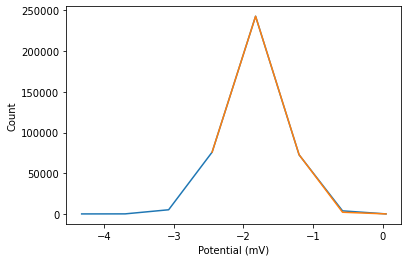

In [9]:
ideal_num_bins_excluded=3 #decide this number by examining where the graphs above plateau...
A = bin_centers[ideal_num_bins_excluded:len(bin_centers)] #values of bin_centers of only the part you need
B = hist[ideal_num_bins_excluded:len(hist)] #values of histogram of only the part you need
coeff, var_matrix = curve_fit(gauss, A, B, p0=p0)
print("Best Estimate Mean: ", coeff[1])
print("Best Estimate Standard Deviation: ", abs(coeff[2]))
hist_fit = gauss(bin_centers[ideal_num_bins_excluded:len(bin_centers)], *coeff)
plt.plot(bin_centers, hist, label='Test data')
plt.plot(bin_centers[ideal_num_bins_excluded:len(bin_centers)], hist_fit, label='Fitted data')
plt.xlabel("Potential (mV)")
plt.ylabel("Count")
plt.show()